In [5]:
!pip install wandb onnx -Uq
!wandb login --relogin
### In order to get the results, you must insert your key below

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Package Importing

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models import alexnet as ALEXNET
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import collections
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import wandb

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Loading

In [8]:
dir = '/content/drive/MyDrive'
files = ['train.pickle', 'validation.pickle', 'test.pickle']

data = {}
for f in files:
  data_ = pd.read_pickle(f'{dir}/{f}')
  image = []
  tag = []
  for d in data_:
    image.append(d[0])
    tag.append(d[1])
  data[f.split('.')[0]] = {'image': np.array(image), 'tag': np.array(tag) - 1}

# Images Visualization

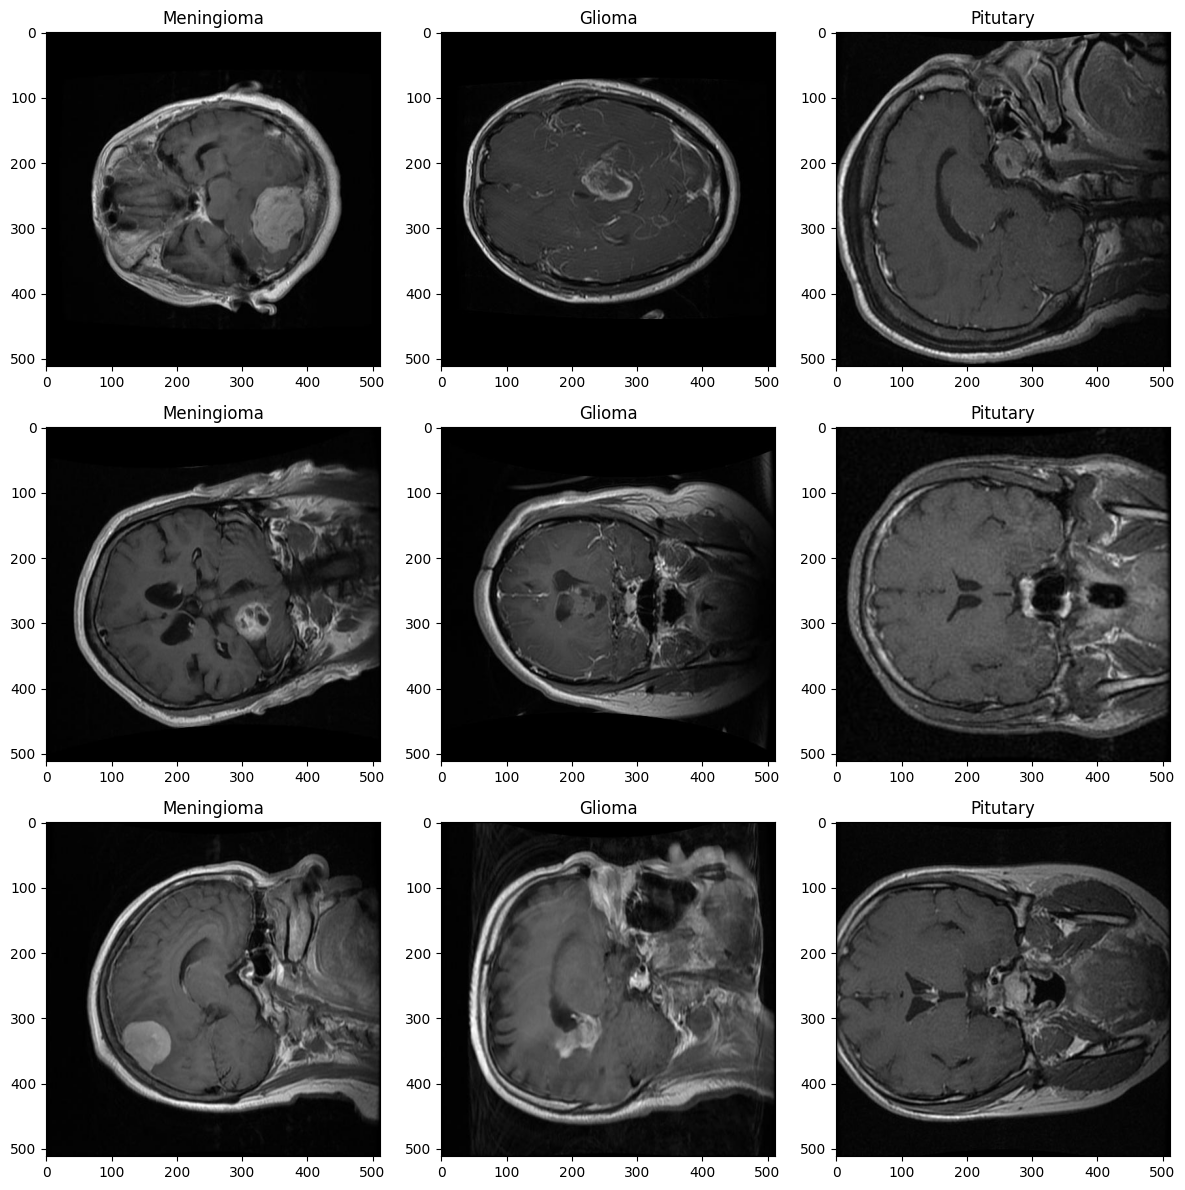

In [9]:
c1 = 0
c2 = 0
c3 = 0
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, tag in enumerate(data['train']['tag']):

    if tag == 0 and c1 < 3:
        axs[c1][0].title.set_text("Meningioma")
        axs[c1][0].imshow(data['train']['image'][i], cmap='gray')
        c1 += 1

    if tag == 1 and c2 < 3:
        axs[c2][1].title.set_text("Glioma")
        axs[c2][1].imshow(data['train']['image'][i], cmap='gray')
        c2 += 1

    if tag == 2 and c3 < 3:
        axs[c3][2].title.set_text("Pitutary")
        axs[c3][2].imshow(data['train']['image'][i], cmap='gray')
        c3 +=1

    if (c1+c2+c3)==9:
        break

fig.tight_layout()

# Database, Dataloader

In [10]:
class CustomDataset(Dataset):

  def __init__(self, img, tag, transformer=None):
    if transformer:
      self.img = [transformer(i) for i in img]
    else:
      self.img = img
    self.tag = tag

  def __len__(self):
    return len(self.img)

  def __getitem__(self, idx):
    x = self.img[idx]
    y = self.tag[idx]
    return x, y

train_transformer = T.Compose([
  T.ToPILImage(),
  T.Resize((224,224)),
  T.RandomHorizontalFlip(p=0.3),
  T.RandomVerticalFlip(p=0.2),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformer = T.Compose([
  T.ToPILImage(),
  T.Resize((224,224)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 32

train_dataset = CustomDataset(data['train']['image'], data['train']['tag'], train_transformer)
val_dataset = CustomDataset(data['validation']['image'], data['validation']['tag'], train_transformer)
test_dataset = CustomDataset(data['test']['image'], data['test']['tag'], test_transformer)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, 1, shuffle=False)

# AlexNet (from scratch)

In [11]:
class AlexNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(3, 96, 11, padding=2, stride=4),
                              nn.ReLU(),
                              nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
                              nn.MaxPool2d(3, 2),
                              nn.Conv2d(96, 256, 5, padding=2),
                              nn.ReLU(),
                              nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
                              nn.MaxPool2d(3, 2),
                              nn.Conv2d(256, 348, 3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(348, 348, 3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(348, 256, 3, padding=1),
                              nn.ReLU(),
                              nn.MaxPool2d(3, 2))

    self.linear = nn.Sequential(nn.Dropout(p=0.5),
                                nn.Linear(6 * 6 * 256, 4096),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(4096, 4096),
                                nn.ReLU(),
                                nn.Linear(4096, 3))
    self.initialize()


  def initialize(self):
    for layer in self.conv:
      if isinstance(layer, nn.Conv2d):
        nn.init.normal_(layer.weight, mean=0, std=0.01)
        nn.init.constant_(layer.bias, 0)

    nn.init.constant_(self.conv[4].bias, 1)
    nn.init.constant_(self.conv[10].bias, 1)
    nn.init.constant_(self.conv[12].bias, 1)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, 1)
    x = self.linear(x)
    return x

myModel = AlexNet().to(device)

# Loss and Training Function

In [12]:
counts = collections.Counter(data['train']['tag'])
weights = np.zeros(len(counts.keys()))
for item in counts.items():
  weights[item[0]] = sum(counts.values()) / (len(counts.values()) * item[1]) # n_samples / (n_classes * n_samplesj)

lr = 1e-4
optimizer = Adam(myModel.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights).to(device))

In [13]:
def model_train(model, loader, optimizer, criterion):
  model.train()
  overall_loss = 0.0
  overall_accuracy = 0.0
  overall_f1 = 0.0
  for x, y in loader:
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    overall_loss += loss.item()
    overall_accuracy += accuracy_score(y.cpu(), pred.argmax(axis=1).cpu())
    overall_f1 += f1_score(y.cpu(), pred.argmax(axis=1).cpu(), average='weighted')
    loss.backward()
    optimizer.step()

  return overall_loss / len(loader), overall_accuracy / len(loader), overall_f1 / len(loader)

def model_validation(model, loader, criterion):
  model.eval()
  overall_loss = 0.0
  overall_accuracy = 0.0
  overall_f1= 0.0
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      pred = model(x)
      loss = criterion(pred, y)
      overall_loss += loss.item()
      overall_accuracy += accuracy_score(y.cpu(), pred.argmax(axis=1).cpu())
      overall_f1 += f1_score(y.cpu(), pred.argmax(axis=1).cpu(), average='weighted')

  return overall_loss / len(loader), overall_accuracy / len(loader), overall_f1 / len(loader)

def model_test(model, loader, criterion):
  model.eval()
  overall_loss = 0.0
  overall_accuracy = 0.0
  overall_f1= 0.0
  y_true = []
  y_pred = []
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      pred = model(x)
      y_true.append(y.item())
      y_pred.append(pred.argmax(axis=1).item())
      loss = criterion(pred, y)
      overall_loss += loss.item()
      overall_accuracy += accuracy_score(y.cpu(), pred.argmax(axis=1).cpu())
      overall_f1 += f1_score(y.cpu(), pred.argmax(axis=1).cpu(), average='weighted')

  return overall_loss / len(loader), overall_accuracy / len(loader), overall_f1 / len(loader), y_true, y_pred

# Wandb Initialize

In [14]:
config = dict(
    epochs=22,
    classes=3,
    kernels=[96, 128, 256, 348, 348, 256],
    batch_size=32,
    learning_rate=1e-4,
    dataset="Custom MRI Images",
    architecture="Alexnet (from scratch)")

wandb.init(project="image", config=config)

wandb: Currently logged in as: aryaz (sharif-bio). Use `wandb login --relogin` to force relogin


# Training

In [15]:
epoch = 22

train_loss = []
train_acc = []
train_f1 = []
val_loss = []
val_acc = []
val_f1 = []

for e in range(epoch):
  print(f'Epoch {e+1}:')
  loss, acc, f1 = model_train(myModel, train_loader, optimizer, criterion)
  train_loss.append(loss)
  train_acc.append(acc)
  train_f1.append(f1)
  print(f'        Train: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')

  loss, acc, f1 = model_validation(myModel, val_loader, criterion)
  val_loss.append(loss)
  val_acc.append(acc)
  val_f1.append(f1)
  print(f'        Val..: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')

  wandb.log({"Train Loss": train_loss[-1],
             "Validation Loss": val_loss[-1],
             "Train Accuracy": train_acc[-1],
             "Validation Accuracy": val_acc[-1],
             "Train F1-score": train_f1[-1],
             "Validation F1-score": val_f1[-1]})
wandb.finish()

Epoch 1:
        Train: Loss = 1.1437, Accuracy = 0.386, F1-score = 0.249
        Val..: Loss = 1.0991, Accuracy = 0.453, F1-score = 0.291
Epoch 2:
        Train: Loss = 1.0998, Accuracy = 0.325, F1-score = 0.222
        Val..: Loss = 1.0987, Accuracy = 0.453, F1-score = 0.289
Epoch 3:
        Train: Loss = 1.0988, Accuracy = 0.328, F1-score = 0.216
        Val..: Loss = 1.0996, Accuracy = 0.416, F1-score = 0.333
Epoch 4:
        Train: Loss = 0.9668, Accuracy = 0.558, F1-score = 0.531
        Val..: Loss = 0.7441, Accuracy = 0.67, F1-score = 0.678
Epoch 5:
        Train: Loss = 0.7409, Accuracy = 0.677, F1-score = 0.679
        Val..: Loss = 0.6994, Accuracy = 0.695, F1-score = 0.698
Epoch 6:
        Train: Loss = 0.635, Accuracy = 0.721, F1-score = 0.723
        Val..: Loss = 0.6419, Accuracy = 0.729, F1-score = 0.726
Epoch 7:
        Train: Loss = 0.595, Accuracy = 0.74, F1-score = 0.743
        Val..: Loss = 0.5853, Accuracy = 0.756, F1-score = 0.759
Epoch 8:
        Train: Loss = 

Train Accuracy,▂▁▁▄▅▆▆▆▇▇▇▇▇▇▇▇██████
Train F1-score,▁▁▁▄▆▆▇▇▇▇▇▇▇▇▇███████
Train Loss,███▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Validation Accuracy,▂▂▁▅▅▆▆▆▇▇▇▆▇▇▇█▇█████
Validation F1-score,▁▁▂▆▆▆▇▇▇▇█▇▇█▇███████
Validation Loss,███▅▄▄▃▃▃▂▂▂▂▁▂▁▂▁▁▁▁▁
Train Accuracy,0.8854
Train F1-score,0.88556
Train Loss,0.26852
Validation Accuracy,0.85903
Validation F1-score,0.86049


# Plotting

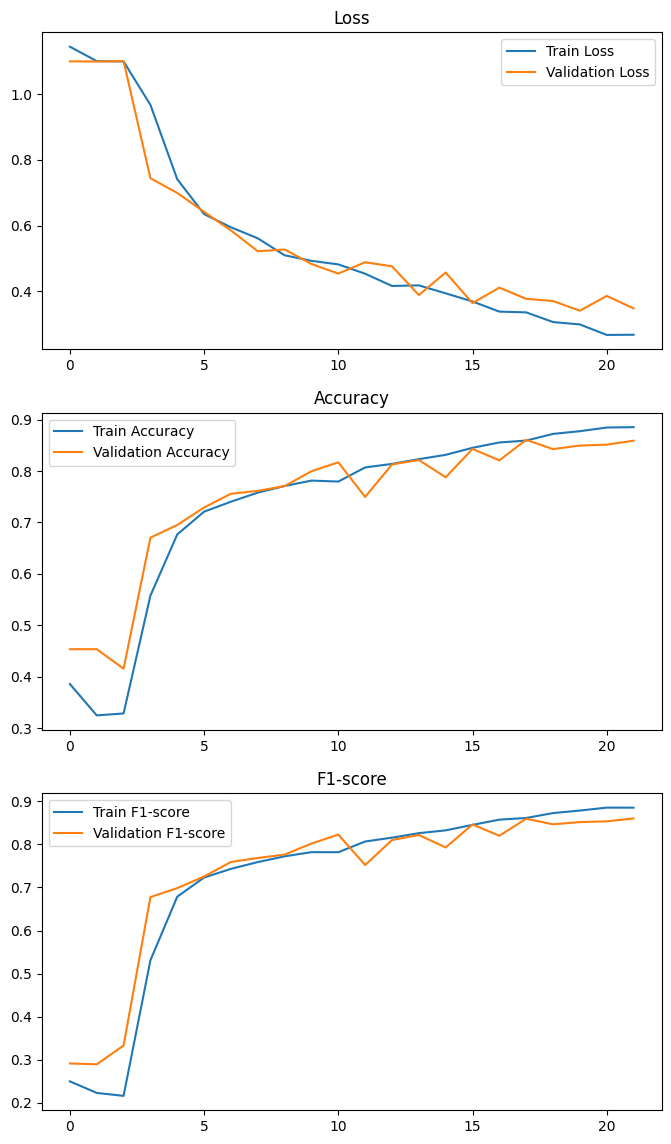

In [16]:
x = np.linspace(0, 21, 22, dtype=int)
fig, ax = plt.subplots(3, 1, figsize=(8, 14))

ax[0].plot(x, train_loss)
ax[0].plot(x, val_loss)
ax[0].legend(['Train Loss', 'Validation Loss'])
ax[0].title.set_text('Loss')

ax[1].plot(x, train_acc)
ax[1].plot(x, val_acc)
ax[1].legend(['Train Accuracy', 'Validation Accuracy'])
ax[1].title.set_text('Accuracy')

ax[2].plot(x, train_f1)
ax[2].plot(x, val_f1)
ax[2].legend(['Train F1-score', 'Validation F1-score'])
ax[2].title.set_text('F1-score')

plt.show()

# Test Dataset

Test: Loss = 0.3548, Accuracy = 0.863, F1-score = 0.863


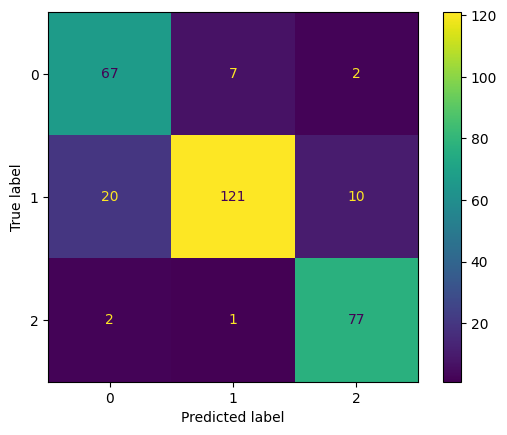

In [17]:
loss, acc, f1, y_true, y_pred = model_test(myModel, test_loader, criterion)
print(f'Test: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Pretrained Alexnet

In [18]:
class CustomAlexnet(nn.Module):
  def __init__(self, alexnet_pretrained):
    super().__init__()
    self.alexnet = nn.Sequential(*list(alexnet_pretrained.children())[:-1])
    self.fc = (nn.Sequential(*list(alexnet_pretrained.children())[-1][:-1],
               nn.Linear(4096, 3)))

  def forward(self, input):
    x = self.alexnet(input)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

alexnet_ = ALEXNET(weights='AlexNet_Weights.DEFAULT')
for child in alexnet_.children():
  for param in child.parameters():
    param.requires_grad = False

alexnet = CustomAlexnet(alexnet_).to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 148MB/s]


In [19]:
config = dict(
    epochs=22,
    classes=3,
    kernels='PyTorch Defaults',
    batch_size=32,
    learning_rate=1e-4,
    dataset="Custom MRI Images",
    architecture="Alexnet (Pretrained)")

wandb.init(project="image", config=config)

In [20]:
epoch = 16

train_loss = []
train_acc = []
train_f1 = []
val_loss = []
val_acc = []
val_f1 = []

optimizer = Adam(alexnet.parameters(), lr=lr, weight_decay=1e-5)
for e in range(epoch):
  print(f'Epoch {e+1}:')
  loss, acc, f1 = model_train(alexnet, train_loader, optimizer, criterion)
  train_loss.append(loss)
  train_acc.append(acc)
  train_f1.append(f1)
  print(f'        Train: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')

  loss, acc, f1 = model_validation(alexnet, val_loader, criterion)
  val_loss.append(loss)
  val_acc.append(acc)
  val_f1.append(f1)
  print(f'        Val..: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')
  wandb.log({"Train Loss": train_loss[-1],
             "Validation Loss": val_loss[-1],
             "Train Accuracy": train_acc[-1],
             "Validation Accuracy": val_acc[-1],
             "Train F1-score": train_f1[-1],
             "Validation F1-score": val_f1[-1]})

Epoch 1:
        Train: Loss = 0.8279, Accuracy = 0.644, F1-score = 0.641
        Val..: Loss = 0.655, Accuracy = 0.737, F1-score = 0.735
Epoch 2:
        Train: Loss = 0.5996, Accuracy = 0.76, F1-score = 0.762
        Val..: Loss = 0.5606, Accuracy = 0.79, F1-score = 0.79
Epoch 3:
        Train: Loss = 0.5257, Accuracy = 0.794, F1-score = 0.798
        Val..: Loss = 0.4915, Accuracy = 0.82, F1-score = 0.823
Epoch 4:
        Train: Loss = 0.4903, Accuracy = 0.813, F1-score = 0.817
        Val..: Loss = 0.4656, Accuracy = 0.826, F1-score = 0.828
Epoch 5:
        Train: Loss = 0.4765, Accuracy = 0.814, F1-score = 0.816
        Val..: Loss = 0.4499, Accuracy = 0.836, F1-score = 0.839
Epoch 6:
        Train: Loss = 0.4418, Accuracy = 0.828, F1-score = 0.832
        Val..: Loss = 0.4347, Accuracy = 0.836, F1-score = 0.838
Epoch 7:
        Train: Loss = 0.4382, Accuracy = 0.83, F1-score = 0.834
        Val..: Loss = 0.4184, Accuracy = 0.838, F1-score = 0.839
Epoch 8:
        Train: Loss = 0.

In [21]:
for child in alexnet.children():
  for param in child.parameters():
    param.requires_grad = True

epoch = 6

optimizer = Adam(alexnet.parameters(), lr=lr, weight_decay=1e-5)
for e in range(epoch):
  print(f'Epoch {e+1}:')
  loss, acc, f1 = model_train(alexnet, train_loader, optimizer, criterion)
  train_loss.append(loss)
  train_acc.append(acc)
  train_f1.append(f1)
  print(f'       Train: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')

  loss, acc, f1 = model_validation(alexnet, val_loader, criterion)
  val_loss.append(loss)
  val_acc.append(acc)
  val_f1.append(f1)
  print(f'       Val..: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')
  wandb.log({"Train Loss": train_loss[-1],
             "Validation Loss": val_loss[-1],
             "Train Accuracy": train_acc[-1],
             "Validation Accuracy": val_acc[-1],
             "Train F1-score": train_f1[-1],
             "Validation F1-score": val_f1[-1]})
wandb.finish()

Epoch 1:
       Train: Loss = 0.3968, Accuracy = 0.84, F1-score = 0.843
       Val..: Loss = 0.4211, Accuracy = 0.836, F1-score = 0.842
Epoch 2:
       Train: Loss = 0.2267, Accuracy = 0.916, F1-score = 0.917
       Val..: Loss = 0.2698, Accuracy = 0.883, F1-score = 0.884
Epoch 3:
       Train: Loss = 0.1537, Accuracy = 0.942, F1-score = 0.943
       Val..: Loss = 0.2324, Accuracy = 0.89, F1-score = 0.894
Epoch 4:
       Train: Loss = 0.1029, Accuracy = 0.964, F1-score = 0.964
       Val..: Loss = 0.6801, Accuracy = 0.82, F1-score = 0.818
Epoch 5:
       Train: Loss = 0.1176, Accuracy = 0.962, F1-score = 0.962
       Val..: Loss = 0.2263, Accuracy = 0.905, F1-score = 0.91
Epoch 6:
       Train: Loss = 0.0566, Accuracy = 0.981, F1-score = 0.982
       Val..: Loss = 0.1594, Accuracy = 0.941, F1-score = 0.943


Train Accuracy,▁▃▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▇▇███
Train F1-score,▁▃▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▇▇███
Train Loss,█▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▂▁▂▁
Validation Accuracy,▁▃▄▄▄▄▄▄▄▅▄▄▅▅▄▄▄▆▆▄▇█
Validation F1-score,▁▃▄▄▅▄▅▄▄▅▄▄▅▅▄▄▅▆▆▄▇█
Validation Loss,█▆▅▅▅▅▄▄▅▄▄▄▄▄▄▄▅▂▂█▂▁
Train Accuracy,0.98133
Train F1-score,0.98153
Train Loss,0.0566
Validation Accuracy,0.94132
Validation F1-score,0.94276


# Plotting

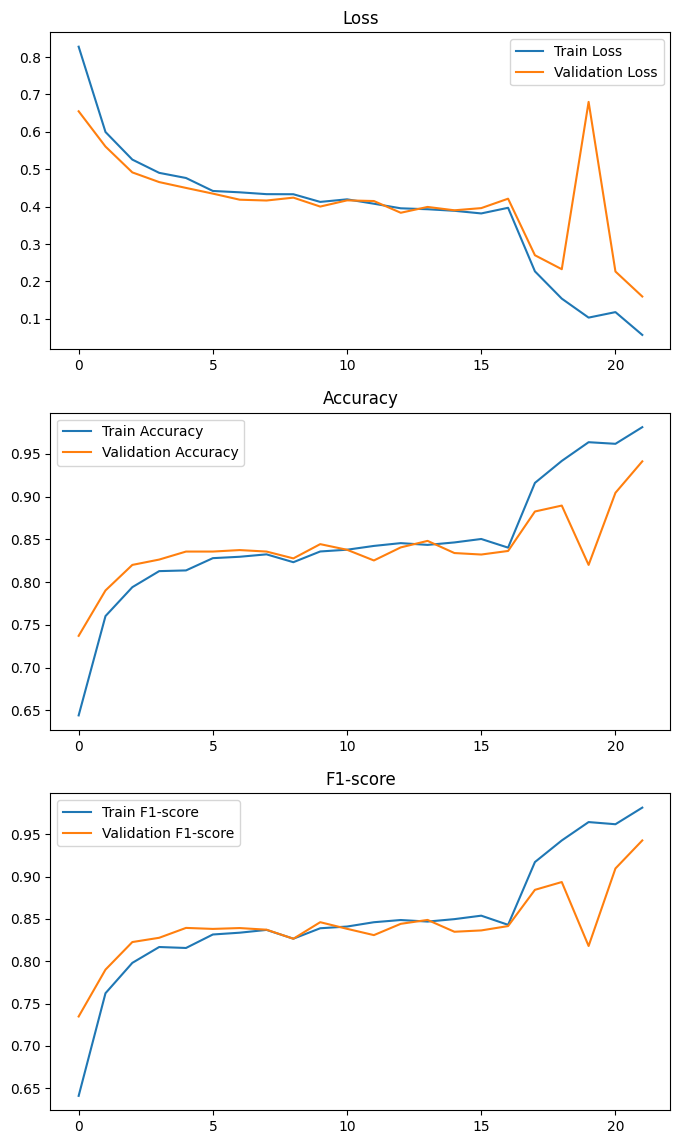

In [22]:
x = np.linspace(0, 21, 22, dtype=int)
fig, ax = plt.subplots(3, 1, figsize=(8, 14))

ax[0].plot(x, train_loss)
ax[0].plot(x, val_loss)
ax[0].legend(['Train Loss', 'Validation Loss'])
ax[0].title.set_text('Loss')

ax[1].plot(x, train_acc)
ax[1].plot(x, val_acc)
ax[1].legend(['Train Accuracy', 'Validation Accuracy'])
ax[1].title.set_text('Accuracy')

ax[2].plot(x, train_f1)
ax[2].plot(x, val_f1)
ax[2].legend(['Train F1-score', 'Validation F1-score'])
ax[2].title.set_text('F1-score')

plt.show()

# Test Dataset

Test: Loss = 0.1276, Accuracy = 0.958, F1-score = 0.958


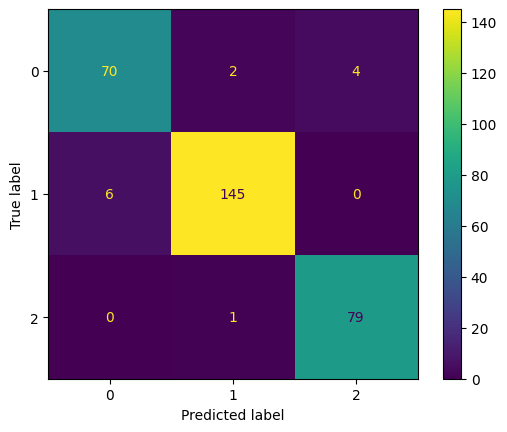

In [23]:
loss, acc, f1, y_true, y_pred = model_test(alexnet, test_loader, criterion)
print(f'Test: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Contrastive Loss Implementation

In [24]:
class CustomDataset(Dataset):

  def __init__(self, img, tag, transformer=None, is_test=False):
    self.img = img
    self.tag = tag
    self.transformer = transformer
    self.is_test = is_test

  def __len__(self):
    return len(self.tag)

  def __getitem__(self, idx):
    y = self.tag[idx]
    x_org = self.transformer(self.img[idx])

    if self.is_test:
      return x_org, y

    x = TF.to_pil_image(self.img[idx])
    x = TF.resize(x, (224, 224))
    x1 = TF.normalize(TF.to_tensor(TF.hflip(x)), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    x2 = TF.normalize(TF.to_tensor(TF.vflip(x)), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    return x_org, x1, x2, y


train_transformer = T.Compose([
  T.ToPILImage(),
  T.Resize((224,224)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformer = T.Compose([
  T.ToPILImage(),
  T.Resize((224,224)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 128

train_dataset = CustomDataset(data['train']['image'], data['train']['tag'], train_transformer)
val_dataset = CustomDataset(data['validation']['image'], data['validation']['tag'], train_transformer)
test_dataset = CustomDataset(data['test']['image'], data['test']['tag'], test_transformer, True)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, 1, shuffle=False)

In [25]:
class AlexNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 96, 11, padding=2, stride=4),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(3, 2),
        nn.Conv2d(96, 256, 5, padding=2),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(3, 2),
        nn.Conv2d(256, 348, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(348, 348, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(348, 256, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
        )

    self.linear = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(6 * 6 * 256, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU()
        )

    self.encoder = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(4096, 2048),
        nn.BatchNorm1d(2048),
        nn.LeakyReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU()
    )

    self.projection = nn.Sequential(
        nn.Linear(512, 64),
        nn.LeakyReLU()
    )

    self.discriminator = nn.Sequential(
        nn.Linear(512, 3),
        nn.ReLU()
    )

    self.initialize()


  def initialize(self):
    for layer in self.conv:
      if isinstance(layer, nn.Conv2d):
        nn.init.normal_(layer.weight, mean=0, std=0.01)
        nn.init.constant_(layer.bias, 0)

    nn.init.constant_(self.conv[4].bias, 1)
    nn.init.constant_(self.conv[10].bias, 1)
    nn.init.constant_(self.conv[12].bias, 1)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, 1)
    x = self.linear(x)
    x = self.encoder(x)
    proj = self.projection(x)
    disc = self.discriminator(x)
    return proj, disc

contrastiveModel = AlexNet().to(device)
for param in contrastiveModel.discriminator.parameters():
  param.requires_grad = False

In [26]:
def contrastive_loss(proj, tag, temperature):
  l = proj.size()[0]
  bsize = len(tag)
  outside = []
  for i in range(l):
    denominator = sum([torch.exp(torch.dot(proj[i], proj[j]) / temperature) for j in range(l) if j != i])
    positives = []
    if i < bsize:
      cur_tag = tag[i]
      for k, tag_ in enumerate(tag):
        if k == i:
          continue
        if tag_ == cur_tag:
          positives.append(k)
          positives.append(k+bsize)
    else:
      cur_tag = tag[i-bsize]
      for k, tag_ in enumerate(tag):
        if k == (i-bsize):
          continue
        if tag_ == cur_tag:
          positives.append(k)
          positives.append(k+bsize)
    if len(positives) != 0:
      inside = []
      for p in positives:
        numerator = torch.exp(torch.dot(proj[i], proj[p]) / temperature)
        inside.append(torch.log(numerator / denominator))

      outside.append(-sum(inside) / len(positives))

  loss = sum(outside) / bsize

  return loss

In [42]:
def model_train_contrastive(model, loader, optimizer, temperature=1, CE=None):
  model.train()
  overall_loss = 0.0
  overall_accuracy = 0.0
  overall_f1 = 0.0
  for x, x1, x2, y in loader:
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)

    optimizer.zero_grad()
    if not CE:
      proj1, _ = model(x1)
      proj2, _ = model(x2)
      loss = contrastive_loss(torch.cat((proj1, proj2)), y, temperature)
    else:
      x = x.to(device)
      _, pred = model(x)
      loss = CE(pred, y)
      overall_accuracy += accuracy_score(y.cpu(), pred.argmax(axis=1).cpu())
      overall_f1 += f1_score(y.cpu(), pred.argmax(axis=1).cpu(), average='weighted')

    overall_loss += loss.item()
    loss.backward()
    optimizer.step()

  if not CE:
    return overall_loss / len(loader)
  return overall_loss / len(loader), overall_accuracy / len(loader), overall_f1 / len(loader)

def model_validation_contrastive(model, loader, temperature=1, CE=None):
  model.eval()
  overall_loss = 0.0
  overall_accuracy = 0.0
  overall_f1= 0.0
  with torch.no_grad():
    for x, x1, x2, y in loader:
      x1, x2, y = x1.to(device), x2.to(device), y.to(device)
      if not CE:
        proj1, _ = model(x1)
        proj2, _ = model(x2)
        loss = contrastive_loss(torch.cat((proj1, proj2)), y, temperature)
      else:
        x = x.to(device)
        _, pred = model(x)
        loss = CE(pred, y)
        overall_accuracy += accuracy_score(y.cpu(), pred.argmax(axis=1).cpu())
        overall_f1 += f1_score(y.cpu(), pred.argmax(axis=1).cpu(), average='weighted')

      overall_loss += loss.item()

  if not CE:
    return overall_loss / len(loader)
  return overall_loss / len(loader), overall_accuracy / len(loader), overall_f1 / len(loader)

def model_test_contrastive(model, loader, criterion):
  model.eval()
  overall_loss = 0.0
  overall_accuracy = 0.0
  overall_f1= 0.0
  y_true = []
  y_pred = []
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      _, pred = model(x)
      y_true.append(y.item())
      y_pred.append(pred.argmax(axis=1).item())
      loss = criterion(pred, y)
      overall_loss += loss.item()
      overall_accuracy += accuracy_score(y.cpu(), pred.argmax(axis=1).cpu())
      overall_f1 += f1_score(y.cpu(), pred.argmax(axis=1).cpu(), average='weighted')

  return overall_loss / len(loader), overall_accuracy / len(loader), overall_f1 / len(loader), y_true, y_pred

In [28]:
config = dict(
    epochs=16,
    classes=3,
    kernels=[96, 128, 256, 348, 348, 256],
    batch_size=32,
    learning_rate=1e-4,
    dataset="Custom MRI Images",
    architecture="Alexnet (Contrastive Loss)")

wandb.init(project="image", config=config)

In [30]:
lr = 1e-4
optimizer = Adam(contrastiveModel.parameters(), lr=lr, weight_decay=1e-5)

epoch = 7

train_loss = []
val_loss = []

for e in range(epoch):
  print(f'Epoch {e+1}:')

  loss = model_train_contrastive(contrastiveModel, train_loader, optimizer, 0.1, None)
  train_loss.append(loss)
  print(f'       Train: Loss = {round(loss, 4)}')

  loss = model_validation_contrastive(contrastiveModel, val_loader, 0.1, None)
  val_loss.append(loss)
  print(f'       Val..: Loss = {round(loss, 4)}')
  wandb.log({"Train Loss": train_loss[-1],
             "Validation Loss": val_loss[-1]})

Epoch 1:
       Train: Loss = 13.7906
       Val..: Loss = 8.1687
Epoch 2:
       Train: Loss = 8.4254
       Val..: Loss = 8.1687
Epoch 3:
       Train: Loss = 8.3295
       Val..: Loss = 8.1687
Epoch 4:
       Train: Loss = 8.3018
       Val..: Loss = 8.1687
Epoch 5:
       Train: Loss = 8.293
       Val..: Loss = 8.1687
Epoch 6:
       Train: Loss = 8.2862
       Val..: Loss = 8.1687
Epoch 7:
       Train: Loss = 8.2802
       Val..: Loss = 8.1687


In [31]:
for param in contrastiveModel.projection.parameters():
  param.requires_grad = False
for param in contrastiveModel.discriminator.parameters():
  param.requires_grad = True

lr = 1e-4
optimizer = Adam(contrastiveModel.parameters(), lr=lr, weight_decay=1e-5)

In [32]:
epoch = 9

train_acc = []
train_f1 = []
val_acc = []
val_f1 = []

for e in range(epoch):
  print(f'Epoch {e+1}:')
  loss, acc, f1 = model_train_contrastive(contrastiveModel, train_loader, optimizer, CE=criterion)
  train_loss.append(loss)
  train_acc.append(acc)
  train_f1.append(f1)
  print(f'       Train: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')

  loss, acc, f1 = model_validation_contrastive(contrastiveModel, val_loader, CE=criterion)
  val_loss.append(loss)
  val_acc.append(acc)
  val_f1.append(f1)
  print(f'       Val..: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')
  wandb.log({"Train Loss": train_loss[-1],
             "Validation Loss": val_loss[-1],
             "Train Accuracy": train_acc[-1],
             "Validation Accuracy": val_acc[-1],
             "Train F1-score": train_f1[-1],
             "Validation F1-score": val_f1[-1]})
wandb.finish()

Epoch 1:
       Train: Loss = 1.1125, Accuracy = 0.295, F1-score = 0.282
       Val..: Loss = 1.0577, Accuracy = 0.354, F1-score = 0.247
Epoch 2:
       Train: Loss = 0.9768, Accuracy = 0.465, F1-score = 0.463
       Val..: Loss = 0.9594, Accuracy = 0.464, F1-score = 0.461
Epoch 3:
       Train: Loss = 0.7892, Accuracy = 0.604, F1-score = 0.608
       Val..: Loss = 1.3234, Accuracy = 0.245, F1-score = 0.104
Epoch 4:
       Train: Loss = 0.6933, Accuracy = 0.664, F1-score = 0.671
       Val..: Loss = 0.7195, Accuracy = 0.685, F1-score = 0.7
Epoch 5:
       Train: Loss = 0.6255, Accuracy = 0.72, F1-score = 0.726
       Val..: Loss = 0.7113, Accuracy = 0.65, F1-score = 0.664
Epoch 6:
       Train: Loss = 0.5348, Accuracy = 0.776, F1-score = 0.781
       Val..: Loss = 0.8848, Accuracy = 0.536, F1-score = 0.509
Epoch 7:
       Train: Loss = 0.5146, Accuracy = 0.784, F1-score = 0.789
       Val..: Loss = 0.5788, Accuracy = 0.766, F1-score = 0.77
Epoch 8:
       Train: Loss = 0.4696, Accuracy

Train Accuracy,▁▃▅▆▇▇▇██
Train F1-score,▁▃▅▆▇▇▇██
Train Loss,█▅▅▅▅▅▅▁▁▁▁▁▁▁▁▁
Validation Accuracy,▂▄▁▆▆▅██▇
Validation F1-score,▂▅▁▇▇▅██▇
Validation Loss,███████▂▁▂▁▁▁▁▁▁
Train Accuracy,0.82504
Train F1-score,0.83141
Train Loss,0.42182
Validation Accuracy,0.70417
Validation F1-score,0.71032


# Plotting

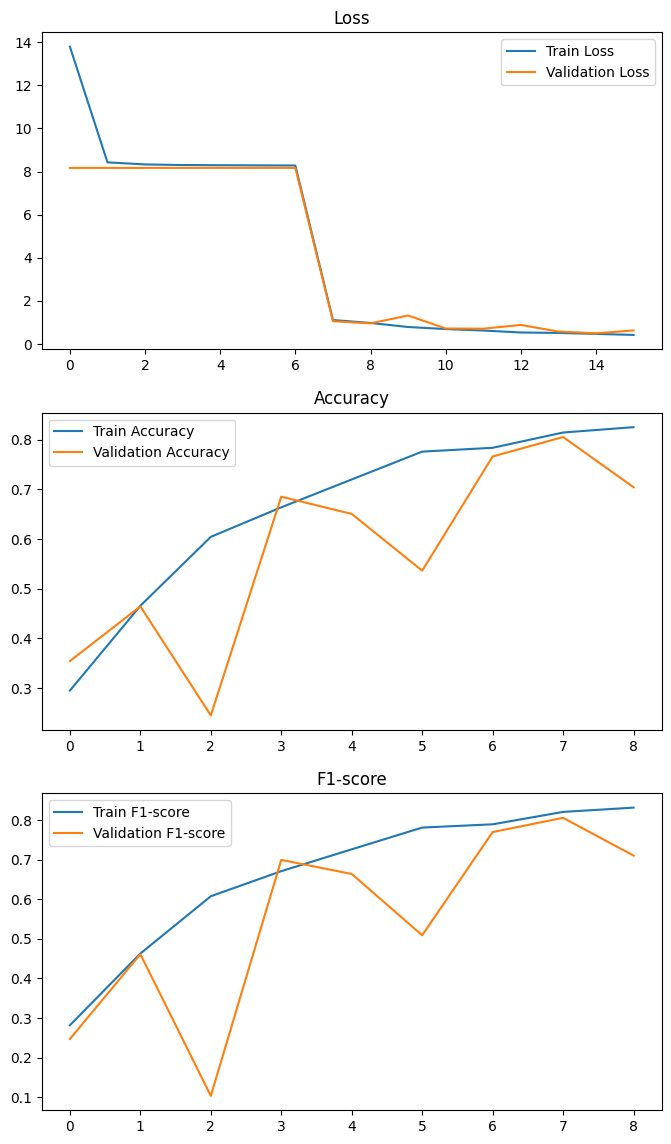

In [34]:
x1 = np.linspace(0, 15, 16, dtype=int)
x2 = np.linspace(0, 8, 9, dtype=int)

fig, ax = plt.subplots(3, 1, figsize=(8, 14))

ax[0].plot(x1, train_loss)
ax[0].plot(x1, val_loss)
ax[0].legend(['Train Loss', 'Validation Loss'])
ax[0].title.set_text('Loss')

ax[1].plot(x2, train_acc)
ax[1].plot(x2, val_acc)
ax[1].legend(['Train Accuracy', 'Validation Accuracy'])
ax[1].title.set_text('Accuracy')

ax[2].plot(x2, train_f1)
ax[2].plot(x2, val_f1)
ax[2].legend(['Train F1-score', 'Validation F1-score'])
ax[2].title.set_text('F1-score')

plt.show()

# Test Dataset

Test: Loss = 0.6915, Accuracy = 0.691, F1-score = 0.691


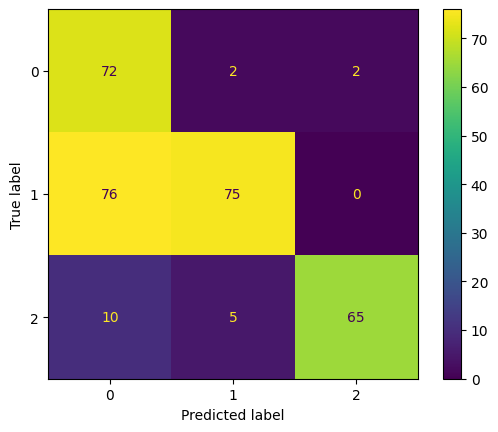

In [44]:
loss, acc, f1, y_true, y_pred = model_test_contrastive(contrastiveModel, test_loader, criterion)
print(f'Test: Loss = {round(loss, 4)}, Accuracy = {round(acc, 3)}, F1-score = {round(f1, 3)}')

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

All wandb reports are in link below:

`https://wandb.ai/sharif-bio/image/reports/MRI-Image-Classification-using-Alexnet--Vmlldzo1ODU2NzAz`